In [73]:
import pandas as pd

# Data Loading

In [74]:
from api.data_handler import DataHandler

# Creation of a DataHandler Object
data_handler = DataHandler(['id', 'col1', 'col2', 'col3', 'col4', 'col5', 'col6', 'col7', 'col8', 'col9', 'col10', 'target_x', 'target_y', 'target_z'])

# Load the Training/Test sets into pandas DataFrames
df_train : pd.DataFrame = data_handler.load_data(f'data/cup/ML-CUP23-TR.csv', delimiter=',')
df_test  : pd.DataFrame = data_handler.load_data(f'data/cup/ML-CUP23-TS.csv', delimiter=',')

# Print the head of the loaded data
print(df_train.head())
print(df_test.head())

   id      col1      col2      col3      col4      col5      col6      col7  \
0   1 -0.917280 -0.712727 -0.989904  0.992819  0.993649  0.995543  0.711074   
1   2 -0.858784  0.998755 -0.998396  0.999909  0.316503 -0.951897 -0.163139   
2   3 -0.990441  0.958726 -0.998675  0.997216  0.987166  0.356483 -0.279689   
3   4  0.937117  0.984474 -0.612420  0.999812  0.728623 -0.539962 -0.165939   
4   5 -0.906628 -0.884567 -0.932487  0.941037  0.978134  0.998179  0.749606   

       col8      col9     col10   target_x   target_y   target_z  
0  0.407645 -0.688548  0.616890   7.897453 -35.936382  21.077147  
1  0.980982  0.661759 -0.800155  -9.330632  19.901571   6.069154  
2  0.599163 -0.684630  0.922901  14.849400   3.374090  19.667479  
3  0.999352 -0.921444 -0.974766 -46.591854  13.734777  17.953600  
4 -0.590599 -0.508268  0.691798   8.217500 -45.885254  14.894251  
   id      col1      col2      col3      col4      col5      col6      col7  \
0   1 -0.983589  0.989514 -0.998539  0.99944

# Data Split

In [75]:
# Saving the ID columns
df_id_train: pd.DataFrame = df_train['id']
df_id_test: pd.DataFrame = df_test['id']

# Drop the ID columns
df_train = df_train.drop(columns=['id'],axis=1).copy(deep=True)
df_test = df_test.drop(columns=['id'],axis=1).copy(deep=True)

# Split of columns and rows (0.8/0.2) into: TR set and Internal TS set
x_train, y_train, x_internal_test, y_internal_test = data_handler.split_data(
    data=df_train,
    cols_name_split=['target_x','target_y','target_z'],
    rows_split_perc=0.8
)

# Split on columns
x_test, y_test = data_handler.split_data(data=df_test, cols_name_split=['target_x','target_y','target_z'])

# Print of the shapes
print(f"[IDs TR SET]: " + str(df_id_train.shape))
print(f"[IDs TS SET]: " + str(df_id_test.shape))
print(f"[TR SET - x]: " + str(x_train.shape))
print(f"[TR SET - y]: " + str(y_train.shape))
print(f"[Internal TS SET - x]: " + str(x_internal_test.shape))
print(f"[Internal TS SET - y]: " + str(y_internal_test.shape))
print(f"[TS SET - x]: " + str(x_test.shape))
print(f"[TS SET - y]: " + str(y_test.shape))

[IDs TR SET]: (1000,)
[IDs TS SET]: (900,)
[TR SET - x]: (800, 10)
[TR SET - y]: (800, 3)
[Internal TS SET - x]: (200, 10)
[Internal TS SET - y]: (200, 3)
[TS SET - x]: (900, 10)
[TS SET - y]: (900, 3)


/Users/gianlucapanzani/anaconda3/envs/ML/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


# Grid Search parameters

In [76]:
# Parameters' space for Grid Search
param_space = { # CUP 0.49
    'input_size': [10],
    'hidden_size': [100, 80],
    'output_size': [3],
    'hidden_layers': [4],
    'hidden_activation': ['Tanh'],
    'output_activation': [''],
    'tolerance': [0.02],
    'learning_rate': [0.00345, 0.0032],
    'batch_size': [64],
    'momentum': [0.8],
    'weight_init': ["glorot_normal"],
    'seed_init': [19],
    'epochs': [700],
    'weight_decay': [0.0001],
    'optimizer': ['SGD'],
    'nesterov': [True],
    'metrics': ['MEE']
}

'param_space = { # CUP 0.53\n    \'input_size\': [10],\n    \'hidden_size\': [100],\n    \'output_size\': [3],\n    \'hidden_layers\': [4],\n    \'hidden_activation\': [\'Tanh\'],\n    \'output_activation\': [\'\'],\n    \'tolerance\': [0.02],\n    \'learning_rate\': [0.0035],\n    \'batch_size\': [64],\n    \'momentum\': [0.8],\n    \'weight_init\': ["glorot_normal"],\n    \'seed_init\': [19],\n    \'epochs\': [700],\n    \'weight_decay\': [0.0001],\n    \'optimizer\': [\'SGD\'],\n    \'nesterov\': [True],\n    \'metrics\': [\'MEE\']\n}'

# Model Selection

## Best Hyperparameters Research

In [77]:
from sklearn.model_selection import KFold
from api.pytorch.nn import NN

# Creation of a BinaryNN objct for each dataset
nn: NN = None

# Different values per dataset
trials = 1
k = 5

# Search of the best Hyperparameters
X = x_train.values.astype(dtype=float)
y = y_train.values.astype(dtype=float)

# K-fold Cross-validation
kfold = KFold(n_splits=k, shuffle=True, random_state=42)

# Sets all the combinations of the entire set of parameters
data_handler.set_params_combinations(params=param_space)

# Gets the list with the combinations of all the parameters
params_combinations = data_handler.get_params_combinations()

# For each iteration we choose the hyperparameters (randomly) and we use them with K-fold CV
for trial, params in enumerate(params_combinations):
#for trial in range(trials):

    # Choose random hyperparameters
    #params = data_handler.random_dictionary(params=param_space)

    # Creation of the Neural Network object
    #nn_i = NN(params=params, current_trial=trial+1, trials=trials)
    nn_i = NN(params=params, current_trial=trial+1, trials=len(params_combinations))
                    
    # For each K-fold returns the indexes of the data splitted in: <X_train,y_train> and <X_val,y_val>
    for train_index, val_index in kfold.split(X, y):
        x_kfold_train, x_kfold_val = X[train_index], X[val_index]
        y_kfold_train, y_kfold_val = y[train_index], y[val_index]

        nn_i.fit(
            x_train=x_kfold_train,
            y_train=y_kfold_train,
            x_val=x_kfold_val,
            y_val=y_kfold_val
        )

    # Case of first assignment
    if nn is None:
        nn = nn_i
    
    # Print the results of this trial
    print("\n------------------ Current Hyperparameters ------------------")
    nn_i.print_training_info()
    print("------------------ CUP Best Hyperparameters -----------------")
    nn.print_training_info()
    print("\n\n")

    # Case of better model found
    if nn_i.is_better_model_than(model=nn):
        nn = nn_i

# Print output
print("### Best Hyperparameters for CUP ###")
nn.print_training_info()
print("\n\n")



------------------ Current Hyperparameters ------------------
 Trial:                    1/4
 Hyperparameters:          {'input_size': 10, 'hidden_size': 100, 'output_size': 3, 'hidden_layers': 4, 'hidden_activation': 'Tanh', 'output_activation': '', 'tolerance': 0.02, 'learning_rate': 0.00345, 'batch_size': 64, 'momentum': 0.8, 'weight_init': 'glorot_normal', 'seed_init': 19, 'epochs': 700, 'weight_decay': 0.0001, 'optimizer': 'SGD', 'nesterov': True, 'metrics': 'MEE'}
 Mean Training Loss:       0.2339019619669611
 Mean Validation Loss:     0.252111672750409
 Mean Training MEE:        0.2717259483320371
 Mean Validation MEE:      0.41977705960188333
------------------ CUP Best Hyperparameters -----------------
 Trial:                    1/4
 Hyperparameters:          {'input_size': 10, 'hidden_size': 100, 'output_size': 3, 'hidden_layers': 4, 'hidden_activation': 'Tanh', 'output_activation': '', 'tolerance': 0.02, 'learning_rate': 0.00345, 'batch_size': 64, 'momentum': 0.8, 'weight_i

## Retraining Phase


### Retraining for CUP ###
 Trial:                    1/4
 Hyperparameters:          {'input_size': 10, 'hidden_size': 100, 'output_size': 3, 'hidden_layers': 4, 'hidden_activation': 'Tanh', 'output_activation': '', 'tolerance': 0.02, 'learning_rate': 0.00345, 'batch_size': 64, 'momentum': 0.8, 'weight_init': 'glorot_normal', 'seed_init': 19, 'epochs': 700, 'weight_decay': 0.0001, 'optimizer': 'SGD', 'nesterov': True, 'metrics': 'MEE'}
 Mean Training Loss:       0.23382070198668162
 Mean Validation Loss:     0.252111672750409
 Mean Training MEE:        0.2716923028228964
 Mean Validation MEE:      0.41977705960188333


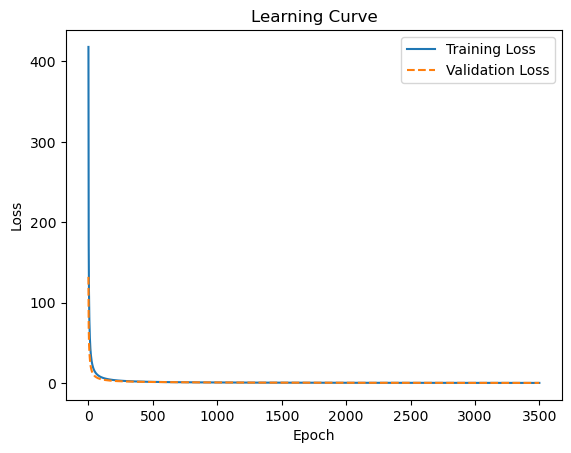

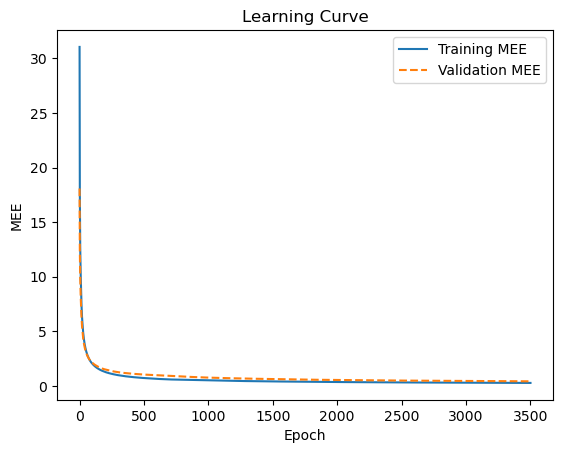

In [78]:
import matplotlib.pyplot as plt

def print_acc_plot(history):
    '''
        Prints the plot based on the accuracy of the trained model.
    '''
    plt.figure()
    plt.plot(history['tr_metric'], label='Training MEE')
    plt.plot(history['vl_metric'], label='Validation MEE', linestyle='--')
    plt.title('Learning Curve')
    plt.xlabel('Epoch')
    plt.ylabel('MEE')
    plt.legend()

# Training the model
nn.fit(
    x_train=x_train.values,
    y_train=y_train.values
)

# Print values
print(f"\n### Retraining for CUP ###")
nn.print_training_info()
nn.print_loss_plot()
nn.print_acc_plot()

# Internal Testing Phase

In [79]:

X = x_internal_test.values
y = y_internal_test.values

# Evaluate the Model on TS set
nn.test(
    x_test=X,
    y_test=y
)

# Prints the results obtained
print(nn)

 Trial:                    1
 Hyperparameters:          {'input_size': 10, 'hidden_size': 100, 'output_size': 3, 'hidden_layers': 4, 'hidden_activation': 'Tanh', 'output_activation': '', 'tolerance': 0.02, 'learning_rate': 0.00345, 'batch_size': 64, 'momentum': 0.8, 'weight_init': 'glorot_normal', 'seed_init': 19, 'epochs': 700, 'weight_decay': 0.0001, 'optimizer': 'SGD', 'nesterov': True, 'metrics': 'MEE'}
 Mean Training Loss:       0.23382070198668162
 Mean Validation Loss:     0.252111672750409
 Mean Test Loss:           0.42373231798410416
 Mean Training MEE:        0.2716923028228964
 Mean Validation MEE:      0.41977705960188333
 Mean Test MEE:            0.9119985476136208



# Predictions' Phase

In [80]:
# Predictions
predictions = nn.predict(x_test=x_test.values)

# Write predictions into file .CSV
data_handler.write_data(
    filename='EmmElle_ML-CUP23-TS.csv',
    id_list=df_id_test.values.tolist(),
    data=predictions,
    cols_name=['id', 'output_x', 'output_y', 'output_z']
)

predictions

[[9.327594757080078, 10.095354080200195, 19.657800674438477],
 [9.548903465270996, -30.54804039001465, 34.41997146606445],
 [10.002269744873047, 7.922506809234619, 20.18364906311035],
 [-12.876266479492188, 12.12026596069336, 23.673070907592773],
 [-48.253292083740234, 11.268285751342773, 30.724035263061523],
 [9.73016357421875, 11.710221290588379, 13.266034126281738],
 [10.003734588623047, 11.592845916748047, 13.372056007385254],
 [9.596556663513184, 12.748028755187988, 6.910646438598633],
 [6.489551544189453, 13.53640079498291, 6.491314888000488],
 [-37.179256439208984, 12.647777557373047, 23.136531829833984],
 [7.080756187438965, 14.115077018737793, 12.383061408996582],
 [10.973006248474121, -36.34228515625, 14.907561302185059],
 [-14.528719902038574, -59.84754943847656, 15.87816047668457],
 [-26.996728897094727, -48.47522735595703, 8.581765174865723],
 [-69.80110931396484, -5.405941486358643, 4.526105880737305],
 [11.984466552734375, 1.0496671199798584, 6.850234508514404],
 [-8.834